# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

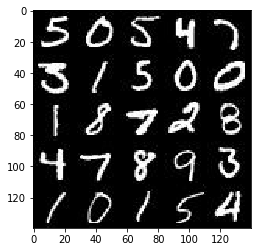

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

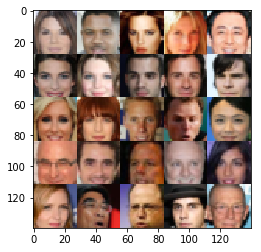

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input_images = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, None)
    return real_input_images, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/usr/lib/python3.5/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'File "/usr/lo

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.01
    
    # input 28*28*3
    with tf.variable_scope('discriminator', reuse=reuse):
        dense_output = tf.layers.dense(images, 32, activation=None); #28*28*32
        leaky_relu_layer_ouput = tf.maximum(alpha * dense_output, dense_output)
        
        conv1_output = tf.layers.conv2d(leaky_relu_layer_ouput, 64, 3, 2, 'same') #stride=2 --> 14*14*64
        leaky_relu_layer_ouput2 = tf.maximum(alpha * conv1_output, conv1_output)
        
        conv2_output = tf.layers.conv2d(leaky_relu_layer_ouput2, 128, 3, 2, 'same') #stride=2 --> 7*7*128
        leaky_relu_layer_ouput3 = tf.maximum(alpha * conv2_output, conv2_output)

        flat_layer = tf.reshape(leaky_relu_layer_ouput3, (-1, 7*7*128))

        logits = tf.layers.dense(flat_layer, 1, activation=None)
        output = tf.sigmoid(logits)

        return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.01
    
    # reshape
    with tf.variable_scope('generator', reuse=not is_train):
        dense_output = tf.layers.dense(z, 7*7*512); 
        dense_output = tf.reshape(dense_output, (-1, 7, 7, 512))
        dense_output = tf.layers.batch_normalization(dense_output, training=is_train)
        dense_output = tf.maximum(alpha * dense_output, dense_output)
        
        conv1_output = tf.layers.conv2d_transpose(dense_output, 256, 5, 1, 'same') # 7*7*256
        conv1_output = tf.layers.batch_normalization(conv1_output, training=is_train)
        conv1_output = tf.maximum(alpha * conv1_output, conv1_output)
        
        conv2_output = tf.layers.conv2d_transpose(conv1_output, 128, 5, 2, 'same') #stride=2 --> 14*14*256
        conv2_output = tf.layers.batch_normalization(conv2_output, training=is_train)
        conv2_output = tf.maximum(alpha * conv2_output, conv2_output)
        
        conv3_output_logits = tf.layers.conv2d_transpose(conv2_output, out_channel_dim, 5, 2, 'same') #stride=2 --> 28*28*out_channel_dim

        output = tf.tanh(conv3_output_logits)

        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth=0.1
        
    # Build the model
    g_model = generator(input_z, out_channel_dim) # g_model is the generator output

    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                    labels=tf.ones_like(d_logits_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                    labels=tf.zeros_like(d_logits_real)))
    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                    labels=tf.ones_like(d_logits_fake)))
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get the trainable_variables, split into G and D parts
    trainable_vars = tf.trainable_variables()
    generator_vars = [var for var in trainable_vars if var.name.startswith('generator')]
    discriminator_vars = [var for var in trainable_vars if var.name.startswith('discriminator')]

    d_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=discriminator_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=generator_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [16]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model    
    input_real, input_z, learn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    discriminator_loss, generator_loss = model_loss(input_real, input_z, data_shape[3])
    discriminator_opt, generator_opt = model_opt(discriminator_loss, generator_loss, learn_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            step = 0
            for batch_images in get_batches(batch_size):
                step +=1
                batch_images = batch_images * 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # Run optimizers
                _ = sess.run(discriminator_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(generator_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                
                if step % 10 == 0:
                    train_loss_d = discriminator_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = generator_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if step % 100 == 0:
                    show_generator_output(sess, show_n_images, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.2971... Generator Loss: 0.8463
Epoch 1/2... Discriminator Loss: 0.6915... Generator Loss: 1.5068
Epoch 1/2... Discriminator Loss: 1.8437... Generator Loss: 1.4091
Epoch 1/2... Discriminator Loss: 0.4715... Generator Loss: 4.0410
Epoch 1/2... Discriminator Loss: 0.4897... Generator Loss: 4.1140
Epoch 1/2... Discriminator Loss: 0.6277... Generator Loss: 3.8964
Epoch 1/2... Discriminator Loss: 0.7244... Generator Loss: 1.8719
Epoch 1/2... Discriminator Loss: 0.6008... Generator Loss: 4.4583
Epoch 1/2... Discriminator Loss: 0.5682... Generator Loss: 5.4719
Epoch 1/2... Discriminator Loss: 0.5486... Generator Loss: 2.8495


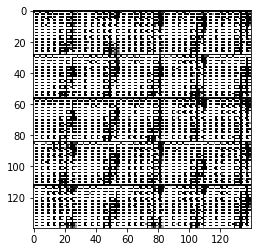

Epoch 1/2... Discriminator Loss: 0.4648... Generator Loss: 2.8010
Epoch 1/2... Discriminator Loss: 0.4199... Generator Loss: 3.5176
Epoch 1/2... Discriminator Loss: 0.5281... Generator Loss: 4.2040
Epoch 1/2... Discriminator Loss: 1.0341... Generator Loss: 1.8933
Epoch 1/2... Discriminator Loss: 1.5037... Generator Loss: 2.5072
Epoch 1/2... Discriminator Loss: 0.6714... Generator Loss: 9.3248
Epoch 1/2... Discriminator Loss: 0.4118... Generator Loss: 7.5060
Epoch 1/2... Discriminator Loss: 0.3590... Generator Loss: 4.7552
Epoch 1/2... Discriminator Loss: 0.3559... Generator Loss: 4.3926
Epoch 1/2... Discriminator Loss: 0.3523... Generator Loss: 5.0909


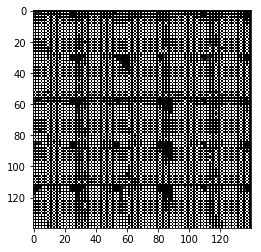

Epoch 1/2... Discriminator Loss: 0.3595... Generator Loss: 5.3697
Epoch 1/2... Discriminator Loss: 0.3950... Generator Loss: 4.4901
Epoch 1/2... Discriminator Loss: 0.4064... Generator Loss: 6.6315
Epoch 1/2... Discriminator Loss: 0.3988... Generator Loss: 5.4468
Epoch 1/2... Discriminator Loss: 0.3678... Generator Loss: 4.7381
Epoch 1/2... Discriminator Loss: 0.3603... Generator Loss: 5.1187
Epoch 1/2... Discriminator Loss: 0.3478... Generator Loss: 5.1569
Epoch 1/2... Discriminator Loss: 0.3523... Generator Loss: 4.8366
Epoch 1/2... Discriminator Loss: 0.3468... Generator Loss: 5.5229
Epoch 1/2... Discriminator Loss: 0.3501... Generator Loss: 5.2771


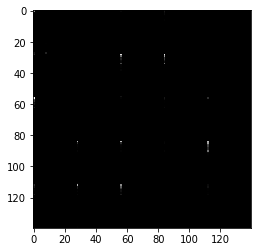

Epoch 1/2... Discriminator Loss: 0.3439... Generator Loss: 5.4560
Epoch 1/2... Discriminator Loss: 0.3411... Generator Loss: 5.4325
Epoch 1/2... Discriminator Loss: 0.3424... Generator Loss: 5.4333
Epoch 1/2... Discriminator Loss: 0.3597... Generator Loss: 5.7319
Epoch 1/2... Discriminator Loss: 0.5980... Generator Loss: 4.5742
Epoch 1/2... Discriminator Loss: 0.5851... Generator Loss: 1.8644
Epoch 1/2... Discriminator Loss: 0.5565... Generator Loss: 4.5864
Epoch 1/2... Discriminator Loss: 0.5019... Generator Loss: 3.3493
Epoch 1/2... Discriminator Loss: 0.4633... Generator Loss: 3.7736
Epoch 1/2... Discriminator Loss: 0.4466... Generator Loss: 4.4131


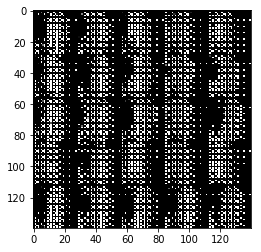

Epoch 1/2... Discriminator Loss: 0.3940... Generator Loss: 4.7170
Epoch 1/2... Discriminator Loss: 0.3997... Generator Loss: 4.6604
Epoch 1/2... Discriminator Loss: 0.3971... Generator Loss: 4.6767
Epoch 1/2... Discriminator Loss: 0.3912... Generator Loss: 4.8611
Epoch 1/2... Discriminator Loss: 0.3732... Generator Loss: 5.6829
Epoch 1/2... Discriminator Loss: 0.3553... Generator Loss: 5.6192
Epoch 2/2... Discriminator Loss: 0.3524... Generator Loss: 5.2013
Epoch 2/2... Discriminator Loss: 0.3468... Generator Loss: 5.4656
Epoch 2/2... Discriminator Loss: 0.3516... Generator Loss: 5.3875
Epoch 2/2... Discriminator Loss: 0.3490... Generator Loss: 5.7030
Epoch 2/2... Discriminator Loss: 0.3467... Generator Loss: 5.7061
Epoch 2/2... Discriminator Loss: 0.3426... Generator Loss: 5.7161
Epoch 2/2... Discriminator Loss: 0.3436... Generator Loss: 5.6196
Epoch 2/2... Discriminator Loss: 0.3407... Generator Loss: 5.8693
Epoch 2/2... Discriminator Loss: 0.3425... Generator Loss: 5.8265
Epoch 2/2.

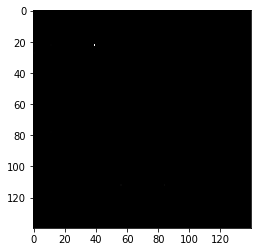

Epoch 2/2... Discriminator Loss: 0.3366... Generator Loss: 5.9464
Epoch 2/2... Discriminator Loss: 0.3352... Generator Loss: 6.0309
Epoch 2/2... Discriminator Loss: 0.3390... Generator Loss: 5.9303
Epoch 2/2... Discriminator Loss: 0.3353... Generator Loss: 6.2434
Epoch 2/2... Discriminator Loss: 0.3380... Generator Loss: 5.7627
Epoch 2/2... Discriminator Loss: 0.3427... Generator Loss: 6.2124
Epoch 2/2... Discriminator Loss: 0.3356... Generator Loss: 6.1495
Epoch 2/2... Discriminator Loss: 0.3369... Generator Loss: 6.1342
Epoch 2/2... Discriminator Loss: 0.3382... Generator Loss: 6.2601
Epoch 2/2... Discriminator Loss: 0.3396... Generator Loss: 6.1318


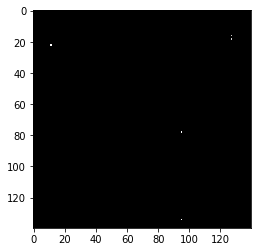

Epoch 2/2... Discriminator Loss: 0.3361... Generator Loss: 6.1965
Epoch 2/2... Discriminator Loss: 0.3322... Generator Loss: 6.2089
Epoch 2/2... Discriminator Loss: 0.3372... Generator Loss: 6.2920
Epoch 2/2... Discriminator Loss: 0.3336... Generator Loss: 6.0472
Epoch 2/2... Discriminator Loss: 0.3351... Generator Loss: 6.6559
Epoch 2/2... Discriminator Loss: 0.3385... Generator Loss: 6.1335
Epoch 2/2... Discriminator Loss: 0.3361... Generator Loss: 6.2887
Epoch 2/2... Discriminator Loss: 0.3346... Generator Loss: 5.9346
Epoch 2/2... Discriminator Loss: 0.3326... Generator Loss: 6.6459
Epoch 2/2... Discriminator Loss: 0.3335... Generator Loss: 6.3059


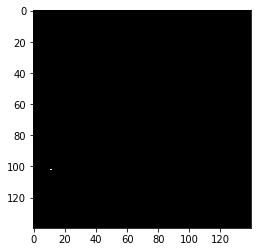

Epoch 2/2... Discriminator Loss: 0.3334... Generator Loss: 6.4192
Epoch 2/2... Discriminator Loss: 0.3334... Generator Loss: 6.3533
Epoch 2/2... Discriminator Loss: 0.3317... Generator Loss: 6.4497
Epoch 2/2... Discriminator Loss: 0.3316... Generator Loss: 6.5337
Epoch 2/2... Discriminator Loss: 0.3320... Generator Loss: 6.2532
Epoch 2/2... Discriminator Loss: 0.3341... Generator Loss: 6.6372
Epoch 2/2... Discriminator Loss: 0.3338... Generator Loss: 6.4790
Epoch 2/2... Discriminator Loss: 0.3323... Generator Loss: 6.1873
Epoch 2/2... Discriminator Loss: 0.4168... Generator Loss: 4.7236
Epoch 2/2... Discriminator Loss: 0.7691... Generator Loss: 3.8882


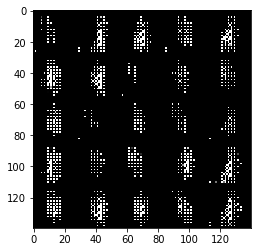

Epoch 2/2... Discriminator Loss: 0.5958... Generator Loss: 3.7759
Epoch 2/2... Discriminator Loss: 0.4809... Generator Loss: 3.8878
Epoch 2/2... Discriminator Loss: 0.4863... Generator Loss: 3.7734
Epoch 2/2... Discriminator Loss: 0.4702... Generator Loss: 4.0644
Epoch 2/2... Discriminator Loss: 0.4828... Generator Loss: 3.4183
Epoch 2/2... Discriminator Loss: 0.4562... Generator Loss: 3.4939


In [17]:
batch_size = 128
z_dim = 200
learning_rate = 0.001
beta1 = 0.25


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.1191... Generator Loss: 0.9669
Epoch 1/1... Discriminator Loss: 0.9348... Generator Loss: 1.2977
Epoch 1/1... Discriminator Loss: 0.5062... Generator Loss: 2.8239
Epoch 1/1... Discriminator Loss: 0.8785... Generator Loss: 2.5412
Epoch 1/1... Discriminator Loss: 0.5113... Generator Loss: 2.3982
Epoch 1/1... Discriminator Loss: 0.4850... Generator Loss: 3.9548
Epoch 1/1... Discriminator Loss: 0.4664... Generator Loss: 4.7481
Epoch 1/1... Discriminator Loss: 0.3912... Generator Loss: 5.2234
Epoch 1/1... Discriminator Loss: 0.3623... Generator Loss: 5.2963
Epoch 1/1... Discriminator Loss: 0.4274... Generator Loss: 5.3096


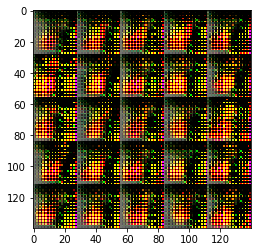

Epoch 1/1... Discriminator Loss: 0.4275... Generator Loss: 4.9498
Epoch 1/1... Discriminator Loss: 0.4939... Generator Loss: 2.9307
Epoch 1/1... Discriminator Loss: 0.5111... Generator Loss: 3.1175
Epoch 1/1... Discriminator Loss: 0.5079... Generator Loss: 3.4283
Epoch 1/1... Discriminator Loss: 0.4632... Generator Loss: 3.9672
Epoch 1/1... Discriminator Loss: 0.5546... Generator Loss: 2.4223
Epoch 1/1... Discriminator Loss: 0.4810... Generator Loss: 3.3000
Epoch 1/1... Discriminator Loss: 0.5334... Generator Loss: 2.7791
Epoch 1/1... Discriminator Loss: 0.9832... Generator Loss: 2.8238
Epoch 1/1... Discriminator Loss: 0.6625... Generator Loss: 2.0252


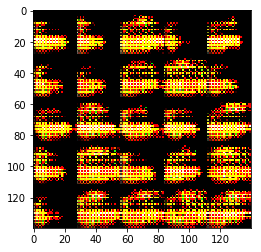

Epoch 1/1... Discriminator Loss: 0.4207... Generator Loss: 3.7792
Epoch 1/1... Discriminator Loss: 0.7711... Generator Loss: 2.3754
Epoch 1/1... Discriminator Loss: 0.5147... Generator Loss: 5.4243
Epoch 1/1... Discriminator Loss: 0.6007... Generator Loss: 4.5344
Epoch 1/1... Discriminator Loss: 0.6498... Generator Loss: 3.1341
Epoch 1/1... Discriminator Loss: 0.4681... Generator Loss: 3.5583
Epoch 1/1... Discriminator Loss: 0.5163... Generator Loss: 2.9399
Epoch 1/1... Discriminator Loss: 0.4134... Generator Loss: 3.8506
Epoch 1/1... Discriminator Loss: 0.4095... Generator Loss: 3.2876
Epoch 1/1... Discriminator Loss: 0.4298... Generator Loss: 3.2018


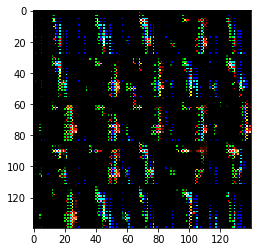

Epoch 1/1... Discriminator Loss: 0.4358... Generator Loss: 3.8825
Epoch 1/1... Discriminator Loss: 0.4650... Generator Loss: 3.8697
Epoch 1/1... Discriminator Loss: 0.4506... Generator Loss: 4.0392
Epoch 1/1... Discriminator Loss: 0.4129... Generator Loss: 3.4444
Epoch 1/1... Discriminator Loss: 0.4589... Generator Loss: 3.4453
Epoch 1/1... Discriminator Loss: 0.5322... Generator Loss: 2.8363
Epoch 1/1... Discriminator Loss: 0.6889... Generator Loss: 2.5369
Epoch 1/1... Discriminator Loss: 0.6716... Generator Loss: 2.5944
Epoch 1/1... Discriminator Loss: 0.5325... Generator Loss: 3.3640
Epoch 1/1... Discriminator Loss: 0.5986... Generator Loss: 3.3641


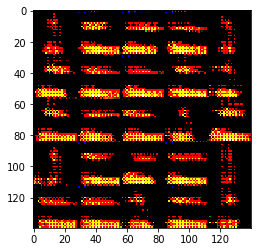

Epoch 1/1... Discriminator Loss: 0.5604... Generator Loss: 3.4876
Epoch 1/1... Discriminator Loss: 0.5442... Generator Loss: 3.5260
Epoch 1/1... Discriminator Loss: 0.8766... Generator Loss: 2.8124
Epoch 1/1... Discriminator Loss: 0.6646... Generator Loss: 2.3308
Epoch 1/1... Discriminator Loss: 0.6867... Generator Loss: 2.9619
Epoch 1/1... Discriminator Loss: 0.4917... Generator Loss: 3.5972
Epoch 1/1... Discriminator Loss: 0.4522... Generator Loss: 3.4414
Epoch 1/1... Discriminator Loss: 0.4278... Generator Loss: 3.7830
Epoch 1/1... Discriminator Loss: 0.4487... Generator Loss: 4.2330
Epoch 1/1... Discriminator Loss: 0.4166... Generator Loss: 4.9800


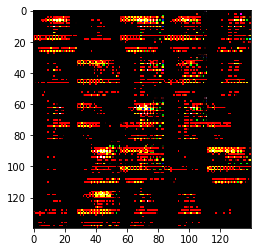

Epoch 1/1... Discriminator Loss: 0.4707... Generator Loss: 2.9753
Epoch 1/1... Discriminator Loss: 0.4986... Generator Loss: 2.9041
Epoch 1/1... Discriminator Loss: 0.4277... Generator Loss: 3.8359
Epoch 1/1... Discriminator Loss: 0.4389... Generator Loss: 3.6558
Epoch 1/1... Discriminator Loss: 0.9473... Generator Loss: 1.0597
Epoch 1/1... Discriminator Loss: 0.6119... Generator Loss: 2.7683
Epoch 1/1... Discriminator Loss: 0.8946... Generator Loss: 1.9738
Epoch 1/1... Discriminator Loss: 0.7490... Generator Loss: 3.1153
Epoch 1/1... Discriminator Loss: 0.4095... Generator Loss: 4.2769
Epoch 1/1... Discriminator Loss: 0.6452... Generator Loss: 2.4197


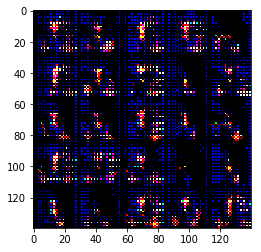

Epoch 1/1... Discriminator Loss: 0.5652... Generator Loss: 3.2177
Epoch 1/1... Discriminator Loss: 0.5302... Generator Loss: 2.7795
Epoch 1/1... Discriminator Loss: 0.7779... Generator Loss: 3.7856
Epoch 1/1... Discriminator Loss: 0.6651... Generator Loss: 2.1506
Epoch 1/1... Discriminator Loss: 0.5793... Generator Loss: 2.8844
Epoch 1/1... Discriminator Loss: 0.5230... Generator Loss: 2.3038
Epoch 1/1... Discriminator Loss: 0.5277... Generator Loss: 2.9607
Epoch 1/1... Discriminator Loss: 0.5327... Generator Loss: 3.2379
Epoch 1/1... Discriminator Loss: 0.5422... Generator Loss: 2.4260
Epoch 1/1... Discriminator Loss: 0.6304... Generator Loss: 4.3948


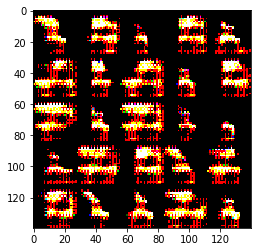

Epoch 1/1... Discriminator Loss: 0.8299... Generator Loss: 4.7120
Epoch 1/1... Discriminator Loss: 0.5483... Generator Loss: 3.5600
Epoch 1/1... Discriminator Loss: 0.5089... Generator Loss: 5.3912
Epoch 1/1... Discriminator Loss: 0.4882... Generator Loss: 4.7242
Epoch 1/1... Discriminator Loss: 0.4475... Generator Loss: 4.4594
Epoch 1/1... Discriminator Loss: 0.5184... Generator Loss: 3.2220
Epoch 1/1... Discriminator Loss: 0.7539... Generator Loss: 2.2783
Epoch 1/1... Discriminator Loss: 0.6424... Generator Loss: 2.3956
Epoch 1/1... Discriminator Loss: 0.6267... Generator Loss: 2.6401
Epoch 1/1... Discriminator Loss: 0.4716... Generator Loss: 3.5409


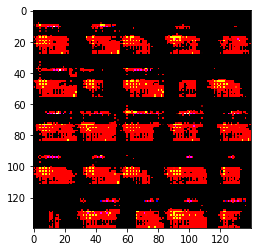

Epoch 1/1... Discriminator Loss: 0.4909... Generator Loss: 3.3456
Epoch 1/1... Discriminator Loss: 0.5092... Generator Loss: 3.4971
Epoch 1/1... Discriminator Loss: 0.4062... Generator Loss: 4.0650
Epoch 1/1... Discriminator Loss: 0.4345... Generator Loss: 3.2531
Epoch 1/1... Discriminator Loss: 0.4663... Generator Loss: 3.0443
Epoch 1/1... Discriminator Loss: 0.6329... Generator Loss: 2.4628
Epoch 1/1... Discriminator Loss: 0.6095... Generator Loss: 2.3431
Epoch 1/1... Discriminator Loss: 0.5315... Generator Loss: 2.8889
Epoch 1/1... Discriminator Loss: 0.6218... Generator Loss: 2.0308
Epoch 1/1... Discriminator Loss: 0.5350... Generator Loss: 3.0464


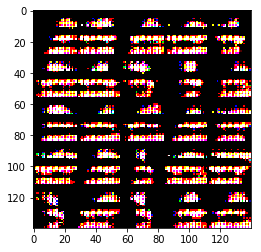

Epoch 1/1... Discriminator Loss: 0.4595... Generator Loss: 3.0296
Epoch 1/1... Discriminator Loss: 0.5328... Generator Loss: 3.0138
Epoch 1/1... Discriminator Loss: 0.5270... Generator Loss: 3.3724
Epoch 1/1... Discriminator Loss: 0.5961... Generator Loss: 3.0358
Epoch 1/1... Discriminator Loss: 0.9166... Generator Loss: 1.3853
Epoch 1/1... Discriminator Loss: 0.6067... Generator Loss: 3.6361
Epoch 1/1... Discriminator Loss: 0.5645... Generator Loss: 3.0465
Epoch 1/1... Discriminator Loss: 0.5825... Generator Loss: 2.4093
Epoch 1/1... Discriminator Loss: 0.6069... Generator Loss: 2.5879
Epoch 1/1... Discriminator Loss: 0.4628... Generator Loss: 4.9229


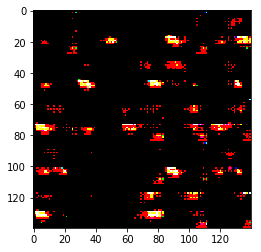

Epoch 1/1... Discriminator Loss: 0.6260... Generator Loss: 2.6393
Epoch 1/1... Discriminator Loss: 0.4723... Generator Loss: 4.0601
Epoch 1/1... Discriminator Loss: 0.5725... Generator Loss: 2.9029
Epoch 1/1... Discriminator Loss: 0.6649... Generator Loss: 2.4833
Epoch 1/1... Discriminator Loss: 0.6453... Generator Loss: 2.6016
Epoch 1/1... Discriminator Loss: 0.5356... Generator Loss: 3.8738
Epoch 1/1... Discriminator Loss: 0.6352... Generator Loss: 2.5878
Epoch 1/1... Discriminator Loss: 0.5460... Generator Loss: 2.5534
Epoch 1/1... Discriminator Loss: 0.6600... Generator Loss: 2.5227
Epoch 1/1... Discriminator Loss: 0.7564... Generator Loss: 3.0965


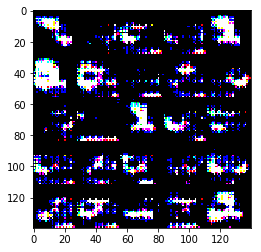

Epoch 1/1... Discriminator Loss: 0.5886... Generator Loss: 3.2583
Epoch 1/1... Discriminator Loss: 0.5940... Generator Loss: 3.0742
Epoch 1/1... Discriminator Loss: 0.6406... Generator Loss: 3.8436
Epoch 1/1... Discriminator Loss: 0.5138... Generator Loss: 2.4527
Epoch 1/1... Discriminator Loss: 0.6410... Generator Loss: 2.5553
Epoch 1/1... Discriminator Loss: 0.8892... Generator Loss: 1.9444
Epoch 1/1... Discriminator Loss: 0.6439... Generator Loss: 2.5171
Epoch 1/1... Discriminator Loss: 0.6569... Generator Loss: 3.0924
Epoch 1/1... Discriminator Loss: 0.6126... Generator Loss: 2.8300
Epoch 1/1... Discriminator Loss: 1.1806... Generator Loss: 2.9869


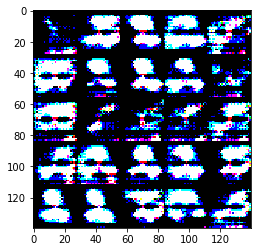

Epoch 1/1... Discriminator Loss: 0.5760... Generator Loss: 5.0447
Epoch 1/1... Discriminator Loss: 0.7545... Generator Loss: 2.2922
Epoch 1/1... Discriminator Loss: 0.5637... Generator Loss: 3.3404
Epoch 1/1... Discriminator Loss: 0.7950... Generator Loss: 2.3102
Epoch 1/1... Discriminator Loss: 0.5281... Generator Loss: 2.9456
Epoch 1/1... Discriminator Loss: 0.5214... Generator Loss: 2.7642
Epoch 1/1... Discriminator Loss: 0.7252... Generator Loss: 2.6636
Epoch 1/1... Discriminator Loss: 0.8094... Generator Loss: 2.2182
Epoch 1/1... Discriminator Loss: 0.5360... Generator Loss: 2.9816
Epoch 1/1... Discriminator Loss: 0.5382... Generator Loss: 2.9491


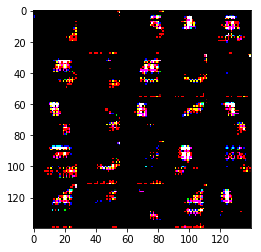

Epoch 1/1... Discriminator Loss: 0.7125... Generator Loss: 2.2842
Epoch 1/1... Discriminator Loss: 0.7116... Generator Loss: 2.1644
Epoch 1/1... Discriminator Loss: 0.6203... Generator Loss: 3.1471
Epoch 1/1... Discriminator Loss: 0.5815... Generator Loss: 3.5849
Epoch 1/1... Discriminator Loss: 0.6129... Generator Loss: 3.9656
Epoch 1/1... Discriminator Loss: 0.8275... Generator Loss: 2.2947
Epoch 1/1... Discriminator Loss: 0.5453... Generator Loss: 2.8171
Epoch 1/1... Discriminator Loss: 0.5909... Generator Loss: 3.0095
Epoch 1/1... Discriminator Loss: 0.5603... Generator Loss: 3.2680
Epoch 1/1... Discriminator Loss: 0.9078... Generator Loss: 2.5317


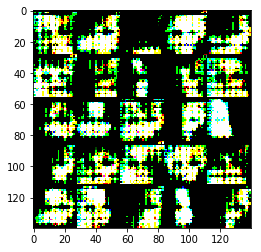

Epoch 1/1... Discriminator Loss: 0.6729... Generator Loss: 2.5484
Epoch 1/1... Discriminator Loss: 0.8721... Generator Loss: 1.9929
Epoch 1/1... Discriminator Loss: 0.7180... Generator Loss: 2.6932
Epoch 1/1... Discriminator Loss: 0.5908... Generator Loss: 2.9924
Epoch 1/1... Discriminator Loss: 0.5648... Generator Loss: 2.6548
Epoch 1/1... Discriminator Loss: 0.6212... Generator Loss: 2.4543
Epoch 1/1... Discriminator Loss: 0.7878... Generator Loss: 2.6396
Epoch 1/1... Discriminator Loss: 0.5956... Generator Loss: 2.4531
Epoch 1/1... Discriminator Loss: 0.6439... Generator Loss: 2.6283
Epoch 1/1... Discriminator Loss: 0.6552... Generator Loss: 2.6598


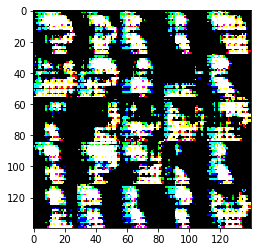

Epoch 1/1... Discriminator Loss: 0.5580... Generator Loss: 2.8751
Epoch 1/1... Discriminator Loss: 0.5005... Generator Loss: 3.3424
Epoch 1/1... Discriminator Loss: 0.5332... Generator Loss: 2.6957
Epoch 1/1... Discriminator Loss: 0.5741... Generator Loss: 2.7482
Epoch 1/1... Discriminator Loss: 0.6659... Generator Loss: 2.6983
Epoch 1/1... Discriminator Loss: 0.5303... Generator Loss: 2.8188
Epoch 1/1... Discriminator Loss: 0.5066... Generator Loss: 3.4089
Epoch 1/1... Discriminator Loss: 0.5954... Generator Loss: 2.7328


In [18]:
batch_size = 128
z_dim = 200
learning_rate = 0.001
beta1 = 0.25

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.